In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
workers = 8
ngpu = 1
beta1 = 0.5
lr = 0.0002
bs = 60
epochs = 60

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv2d(12, 12, kernel_size = 5, padding = 2)
        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv1(xb))
        xb = torch.sigmoid(self.conv2(xb))
        
        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x, b_y))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess)
valid_dl = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.5866379737854004
1 0.41648297309875487
2 0.3504869878292084
3 0.33108386397361755
4 0.31881060004234313
5 0.30697677135467527
6 0.29411437511444094
7 0.27993696331977846
8 0.2657950818538666
9 0.2552846521139145
10 0.24872917234897612
11 0.24375364184379578
12 0.2402591198682785
13 0.23767023980617524
14 0.23569607734680176
15 0.2341536581516266
16 0.2329021543264389
17 0.23185755014419557
18 0.2309671014547348
19 0.23019733428955078
20 0.22952451109886168
21 0.22893142700195312
22 0.22840553522109985
23 0.22793739140033722
24 0.22751958072185516
25 0.22714594304561614
26 0.22681120038032532
27 0.22651086747646332
28 0.22624093890190125
29 0.22599791288375853
30 0.22577858865261077
31 0.22558013200759888
32 0.22540006637573243
33 0.2252361834049225
34 0.2250865340232849
35 0.2249494045972824
36 0.2248232454061508
37 0.22470683753490447
38 0.22459895312786102
39 0.22449865639209748
40 0.2244050532579422
41 0.22431741654872894
42 0.22423509061336516
43 0.22415745556354522
44 0.224084

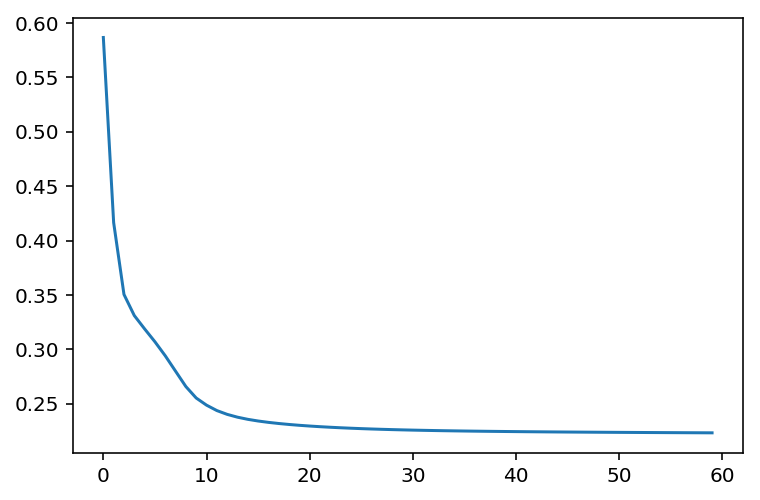

In [14]:
plt.plot(val_losses)
plt.show()

In [15]:
torch.save(model, "SR_model_2.3.ml")

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SuperResolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>